In [1]:
from IPython.display import display
from IPython.core.display import HTML
%load_ext autoreload
%load_ext time
%autoreload 2
%autosave 60
%matplotlib inline

display(HTML("<style>.container { width:80% !important; }</style>"))

The time module is not an IPython extension.


Autosaving every 60 seconds


In [4]:
import pandas as pd
import numpy as np
import folium
import geojson
import geopandas
import osmnx as ox
import networkx as nx
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

from exploration_utils import plot_counter, plot_counters, plot_locations, inspect_diff_area, plot_scatters
from exploration_utils import plot_speed_dayline, plot_flow_dayline, compute_highway_stats

RELEASE_PATH = Path('/private/data/mets10/release20221026_residential_unclassified/2021')
COUNTER_PATH = Path('/private/data/mets10/loop_counters')

### Load road graph

In [5]:
edges_df = geopandas.read_parquet(RELEASE_PATH / 'road_graph' / 'berlin' / 'road_graph_edges.parquet')
edges_df

,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,gkey,gkey_duplicate
0,172539,34694265,4610047,50.0,50,tertiary,False,2,nan,237.653,"LINESTRING (13.33550 52.56521, 13.33560 52.565...",-3971496816046082083,False
1,172539,34694336,5117633,50.0,50,secondary,False,2,nan,687.484,"LINESTRING (13.33550 52.56521, 13.33565 52.565...",2326228620965926186,False
2,172539,3977742457,"[31740296, 33231778]",50.0,50,secondary,False,2,nan,391.153,"LINESTRING (13.33550 52.56521, 13.33533 52.565...",2614055561458146260,False
3,172545,271370539,24973218,50.0,50,tertiary,False,nan,nan,17.179,"LINESTRING (13.34661 52.56703, 13.34664 52.56688)",2643617644203282644,False
4,172545,28345515,4546470,50.0,50,tertiary,False,2,nan,171.849,"LINESTRING (13.34661 52.56703, 13.34659 52.567...",2880417045848662166,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88889,10127802276,10127802275,1106795797,30.7,nan,residential,False,nan,nan,77.387,"LINESTRING (13.22046 52.75400, 13.22022 52.754...",8934902135505775562,False
88890,10129847819,4903730286,204241738,30.7,nan,residential,False,nan,nan,17.104,"LINESTRING (13.19408 52.77172, 13.19400 52.77186)",5366806438097253443,False
88891,10129847819,63040146,26470642,30.7,nan,residential,False,nan,nan,130.257,"LINESTRING (13.19408 52.77172, 13.19352 52.771...",-8214173331135148929,False
88892,10129847819,63044627,204241738,30.7,nan,residential,False,nan,nan,137.819,"LINESTRING (13.19408 52.77172, 13.19414 52.771...",-430835000069930852,False


### Load loop counter locations matched

In [7]:
counters_assigned_df = geopandas.read_parquet(RELEASE_PATH / 'road_graph' / 'berlin' / 'counters_matched.parquet')
print(len(counters_assigned_df))
counters_assigned_df = counters_assigned_df[counters_assigned_df['way'] != -1]
counters_assigned_df

547


,id,lat,lon,heading,name,ways,way_dists,way,way_dist,u,v,geometry
0,100101010000167,52.433868,13.192578,225,TE001_Det_HF1,"[(484310, 27088394, 0), (27088393, 274115813, ...","[1.6619848854382284, 12.674320256897182, 13.87...","[81629728, 150912137]",1.661985,484310,27088394,POINT (13.19258 52.43387)
1,100101010000268,52.433868,13.192578,225,TE001_Det_HF2,"[(484310, 27088394, 0), (27088393, 274115813, ...","[1.6619848854382284, 12.674320256897182, 13.87...","[81629728, 150912137]",1.661985,484310,27088394,POINT (13.19258 52.43387)
2,100101010000369,52.433813,13.192747,45,TE002_Det_HF1,"[(27088393, 274115813, 0), (268076066, 2619099...","[0.7473601310109975, 5.883360599936063, 5.8833...","[4402002, 120233963, 233307349, 92093079]",0.747360,27088393,274115813,POINT (13.19275 52.43381)
3,100101010000470,52.433813,13.192747,45,TE002_Det_HF2,"[(27088393, 274115813, 0), (268076066, 2619099...","[0.7473601310109975, 5.883360599936063, 5.8833...","[4402002, 120233963, 233307349, 92093079]",0.747360,27088393,274115813,POINT (13.19275 52.43381)
4,100101010000874,52.436642,13.261301,180,TE004_Det_HF1,"[(150895819, 26162586, 0), (26905938, 26906132...","[0.6433814473254731, 9.59534207976239]","[43336764, 329983269]",0.643381,150895819,26162586,POINT (13.26130 52.43664)
...,...,...,...,...,...,...,...,...,...,...,...,...
542,100101010097975,52.457440,13.384196,0,TE583_Det_HF2,"[(27556652, 29674292, 0), (29674290, 26876325,...","[6.561686063168479, 14.389146856550148]","[1067561756, 1067561757, 171364191]",6.561686,27556652,29674292,POINT (13.38420 52.45744)
543,100101010099692,52.509232,13.301719,180,TE592_Det_HF1,"[(26736176, 26736175, 0), (26736157, 26736154,...","[6.177326915871354, 17.91124377691932]",724621035,6.177327,26736176,26736175,POINT (13.30172 52.50923)
544,100101010099793,52.509232,13.301719,180,TE592_Det_HF2,"[(26736176, 26736175, 0), (26736157, 26736154,...","[6.177326915871354, 17.91124377691932]",724621035,6.177327,26736176,26736175,POINT (13.30172 52.50923)
545,100101010099894,52.508531,13.302183,0,TE593_Det_HF1,"[(26736157, 26736154, 0), (26736176, 26736175,...","[6.249463950609168, 17.945597051981217]","[1056616525, 327805903]",6.249464,26736157,26736154,POINT (13.30218 52.50853)


In [8]:
compute_highway_stats(counters_assigned_df, edges_df)

,count,share,share_full
highway,,,
motorway,4,1 %,0.729927
primary,219,40 %,39.963504
residential,9,2 %,1.642336
secondary,285,52 %,52.007299
tertiary,22,4 %,4.014599
trunk,6,1 %,1.094891
unclassified,3,1 %,0.547445


### Load loop counter speed values (2019-06-04 is a Tuesday)

In [10]:
loop_counter_speed_files = sorted(list((COUNTER_PATH / 'berlin' / 'speed').glob('*.parquet')))
loop_counter_speed_files[:3]

[PosixPath('/private/data/mets10/loop_counters/berlin/speed/counters_2019-06.parquet'),
 PosixPath('/private/data/mets10/loop_counters/berlin/speed/counters_2021-07.parquet')]

In [11]:
counter_speed_df = pd.read_parquet(COUNTER_PATH / 'berlin' / 'speed' / 'counters_2019-06.parquet')
counter_speed_df

,id,tag,stunde,qualitaet,q_kfz_det_hr,v_kfz_det_hr,q_pkw_det_hr,v_pkw_det_hr,q_lkw_det_hr,v_lkw_det_hr,name,heading,lane,lon,lat,time_bin
0,100101010000167,01.06.2019,0,1.0,227,82.8,207,83.9,20,71.6,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-01 00:00
1,100101010000167,01.06.2019,1,1.0,131,78.4,115,80.5,16,63.7,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-01 01:00
2,100101010000167,01.06.2019,2,1.0,94,77.0,74,80.6,20,63.3,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-01 02:00
3,100101010000167,01.06.2019,3,1.0,83,76.4,68,76.2,15,77.3,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-01 03:00
4,100101010000167,01.06.2019,4,1.0,131,76.9,118,78.8,13,59.9,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-01 04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373734,100101010099995,30.06.2019,19,1.0,191,43.4,189,43.4,2,42.0,TE593_Det_HF2,0,HF_2vR,13.302183,52.508531,2019-06-30 19:00
373735,100101010099995,30.06.2019,20,1.0,219,42.2,216,42.4,3,27.3,TE593_Det_HF2,0,HF_2vR,13.302183,52.508531,2019-06-30 20:00
373736,100101010099995,30.06.2019,21,1.0,265,39.6,257,39.9,8,29.5,TE593_Det_HF2,0,HF_2vR,13.302183,52.508531,2019-06-30 21:00
373737,100101010099995,30.06.2019,22,1.0,158,43.2,157,43.3,1,42.0,TE593_Det_HF2,0,HF_2vR,13.302183,52.508531,2019-06-30 22:00


In [12]:
counter_speed_df['day'] = [tb[:10] for tb in counter_speed_df['time_bin']]
counter_speed_df['h'] = counter_speed_df['stunde']
counter_speed_df['speed_counter'] = counter_speed_df['v_kfz_det_hr'].astype(float)
counter_speed_df['volume'] = counter_speed_df['q_kfz_det_hr'].astype(int)
counter_speed_df

,id,tag,stunde,qualitaet,q_kfz_det_hr,v_kfz_det_hr,q_pkw_det_hr,v_pkw_det_hr,q_lkw_det_hr,v_lkw_det_hr,name,heading,lane,lon,lat,time_bin,day,h,speed_counter,volume
0,100101010000167,01.06.2019,0,1.0,227,82.8,207,83.9,20,71.6,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-01 00:00,2019-06-01,0,82.8,227
1,100101010000167,01.06.2019,1,1.0,131,78.4,115,80.5,16,63.7,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-01 01:00,2019-06-01,1,78.4,131
2,100101010000167,01.06.2019,2,1.0,94,77.0,74,80.6,20,63.3,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-01 02:00,2019-06-01,2,77.0,94
3,100101010000167,01.06.2019,3,1.0,83,76.4,68,76.2,15,77.3,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-01 03:00,2019-06-01,3,76.4,83
4,100101010000167,01.06.2019,4,1.0,131,76.9,118,78.8,13,59.9,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-01 04:00,2019-06-01,4,76.9,131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373734,100101010099995,30.06.2019,19,1.0,191,43.4,189,43.4,2,42.0,TE593_Det_HF2,0,HF_2vR,13.302183,52.508531,2019-06-30 19:00,2019-06-30,19,43.4,191
373735,100101010099995,30.06.2019,20,1.0,219,42.2,216,42.4,3,27.3,TE593_Det_HF2,0,HF_2vR,13.302183,52.508531,2019-06-30 20:00,2019-06-30,20,42.2,219
373736,100101010099995,30.06.2019,21,1.0,265,39.6,257,39.9,8,29.5,TE593_Det_HF2,0,HF_2vR,13.302183,52.508531,2019-06-30 21:00,2019-06-30,21,39.6,265
373737,100101010099995,30.06.2019,22,1.0,158,43.2,157,43.3,1,42.0,TE593_Det_HF2,0,HF_2vR,13.302183,52.508531,2019-06-30 22:00,2019-06-30,22,43.2,158


In [13]:
counter_speed_df[counter_speed_df['day'] == '2019-06-05']

,id,tag,stunde,qualitaet,q_kfz_det_hr,v_kfz_det_hr,q_pkw_det_hr,v_pkw_det_hr,q_lkw_det_hr,v_lkw_det_hr,name,heading,lane,lon,lat,time_bin,day,h,speed_counter,volume
64,100101010000167,05.06.2019,0,1.0,259,74.3,223,74.9,36,71.0,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-05 00:00,2019-06-05,0,74.3,259
65,100101010000167,05.06.2019,1,1.0,125,72.2,96,76.3,29,58.7,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-05 01:00,2019-06-05,1,72.2,125
66,100101010000167,05.06.2019,2,1.0,108,67.8,63,76.7,45,55.4,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-05 02:00,2019-06-05,2,67.8,108
67,100101010000167,05.06.2019,3,1.0,125,69.0,89,72.0,36,61.5,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-05 03:00,2019-06-05,3,69.0,125
68,100101010000167,05.06.2019,4,1.0,224,70.6,165,72.9,59,64.2,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-05 04:00,2019-06-05,4,70.6,224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373134,100101010099995,05.06.2019,19,1.0,332,41.0,327,41.3,5,24.2,TE593_Det_HF2,0,HF_2vR,13.302183,52.508531,2019-06-05 19:00,2019-06-05,19,41.0,332
373135,100101010099995,05.06.2019,20,1.0,266,40.7,262,40.9,4,30.0,TE593_Det_HF2,0,HF_2vR,13.302183,52.508531,2019-06-05 20:00,2019-06-05,20,40.7,266
373136,100101010099995,05.06.2019,21,1.0,194,35.8,192,35.8,2,35.0,TE593_Det_HF2,0,HF_2vR,13.302183,52.508531,2019-06-05 21:00,2019-06-05,21,35.8,194
373137,100101010099995,05.06.2019,22,1.0,189,44.1,187,44.1,2,48.0,TE593_Det_HF2,0,HF_2vR,13.302183,52.508531,2019-06-05 22:00,2019-06-05,22,44.1,189


In [14]:
# Select a single day and merge with the locations
counter_speeds_20190605 = counter_speed_df[counter_speed_df['day'] == '2019-06-05'].merge(
    counters_assigned_df[['id', 'way', 'u', 'v']], on=['id'])
counter_speeds_20190605

,id,tag,stunde,qualitaet,q_kfz_det_hr,v_kfz_det_hr,q_pkw_det_hr,v_pkw_det_hr,q_lkw_det_hr,v_lkw_det_hr,...,lon,lat,time_bin,day,h,speed_counter,volume,way,u,v
0,100101010000167,05.06.2019,0,1.0,259,74.3,223,74.9,36,71.0,...,13.192578,52.433868,2019-06-05 00:00,2019-06-05,0,74.3,259,"[81629728, 150912137]",484310,27088394
1,100101010000167,05.06.2019,1,1.0,125,72.2,96,76.3,29,58.7,...,13.192578,52.433868,2019-06-05 01:00,2019-06-05,1,72.2,125,"[81629728, 150912137]",484310,27088394
2,100101010000167,05.06.2019,2,1.0,108,67.8,63,76.7,45,55.4,...,13.192578,52.433868,2019-06-05 02:00,2019-06-05,2,67.8,108,"[81629728, 150912137]",484310,27088394
3,100101010000167,05.06.2019,3,1.0,125,69.0,89,72.0,36,61.5,...,13.192578,52.433868,2019-06-05 03:00,2019-06-05,3,69.0,125,"[81629728, 150912137]",484310,27088394
4,100101010000167,05.06.2019,4,1.0,224,70.6,165,72.9,59,64.2,...,13.192578,52.433868,2019-06-05 04:00,2019-06-05,4,70.6,224,"[81629728, 150912137]",484310,27088394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12951,100101010099995,05.06.2019,19,1.0,332,41.0,327,41.3,5,24.2,...,13.302183,52.508531,2019-06-05 19:00,2019-06-05,19,41.0,332,"[1056616525, 327805903]",26736157,26736154
12952,100101010099995,05.06.2019,20,1.0,266,40.7,262,40.9,4,30.0,...,13.302183,52.508531,2019-06-05 20:00,2019-06-05,20,40.7,266,"[1056616525, 327805903]",26736157,26736154
12953,100101010099995,05.06.2019,21,1.0,194,35.8,192,35.8,2,35.0,...,13.302183,52.508531,2019-06-05 21:00,2019-06-05,21,35.8,194,"[1056616525, 327805903]",26736157,26736154
12954,100101010099995,05.06.2019,22,1.0,189,44.1,187,44.1,2,48.0,...,13.302183,52.508531,2019-06-05 22:00,2019-06-05,22,44.1,189,"[1056616525, 327805903]",26736157,26736154


In [15]:
def is_valid_counter(s):
    h = np.histogram(s, bins=2)
    return h[-1][-1]

invalid_counters = counter_speeds_20190605[['id', 'speed_counter']].groupby(by=['id']).agg(list).reset_index()
invalid_counters['shist'] = [is_valid_counter(s) for s in invalid_counters['speed_counter']]
invalid_counters = invalid_counters[invalid_counters['shist'] < 1]
invalid_counters

,id,speed_counter,shist
30,100101010004110,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",-0.5
323,100101010060084,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",-0.5


In [16]:
counter_speeds_20190605 = counter_speeds_20190605[~counter_speeds_20190605['id'].isin(invalid_counters['id'])]
counter_speeds_20190605

,id,tag,stunde,qualitaet,q_kfz_det_hr,v_kfz_det_hr,q_pkw_det_hr,v_pkw_det_hr,q_lkw_det_hr,v_lkw_det_hr,...,lon,lat,time_bin,day,h,speed_counter,volume,way,u,v
0,100101010000167,05.06.2019,0,1.0,259,74.3,223,74.9,36,71.0,...,13.192578,52.433868,2019-06-05 00:00,2019-06-05,0,74.3,259,"[81629728, 150912137]",484310,27088394
1,100101010000167,05.06.2019,1,1.0,125,72.2,96,76.3,29,58.7,...,13.192578,52.433868,2019-06-05 01:00,2019-06-05,1,72.2,125,"[81629728, 150912137]",484310,27088394
2,100101010000167,05.06.2019,2,1.0,108,67.8,63,76.7,45,55.4,...,13.192578,52.433868,2019-06-05 02:00,2019-06-05,2,67.8,108,"[81629728, 150912137]",484310,27088394
3,100101010000167,05.06.2019,3,1.0,125,69.0,89,72.0,36,61.5,...,13.192578,52.433868,2019-06-05 03:00,2019-06-05,3,69.0,125,"[81629728, 150912137]",484310,27088394
4,100101010000167,05.06.2019,4,1.0,224,70.6,165,72.9,59,64.2,...,13.192578,52.433868,2019-06-05 04:00,2019-06-05,4,70.6,224,"[81629728, 150912137]",484310,27088394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12951,100101010099995,05.06.2019,19,1.0,332,41.0,327,41.3,5,24.2,...,13.302183,52.508531,2019-06-05 19:00,2019-06-05,19,41.0,332,"[1056616525, 327805903]",26736157,26736154
12952,100101010099995,05.06.2019,20,1.0,266,40.7,262,40.9,4,30.0,...,13.302183,52.508531,2019-06-05 20:00,2019-06-05,20,40.7,266,"[1056616525, 327805903]",26736157,26736154
12953,100101010099995,05.06.2019,21,1.0,194,35.8,192,35.8,2,35.0,...,13.302183,52.508531,2019-06-05 21:00,2019-06-05,21,35.8,194,"[1056616525, 327805903]",26736157,26736154
12954,100101010099995,05.06.2019,22,1.0,189,44.1,187,44.1,2,48.0,...,13.302183,52.508531,2019-06-05 22:00,2019-06-05,22,44.1,189,"[1056616525, 327805903]",26736157,26736154


### Load T4c speed values

In [19]:
speed_files = sorted(list((RELEASE_PATH / 'speed_classes' / 'berlin').glob('*.parquet')))
speed_files[:4]

[PosixPath('/private/data/mets10/release20221026_residential_unclassified/2021/speed_classes/berlin/speed_classes_2019-01-02.parquet'),
 PosixPath('/private/data/mets10/release20221026_residential_unclassified/2021/speed_classes/berlin/speed_classes_2019-01-03.parquet'),
 PosixPath('/private/data/mets10/release20221026_residential_unclassified/2021/speed_classes/berlin/speed_classes_2019-01-04.parquet'),
 PosixPath('/private/data/mets10/release20221026_residential_unclassified/2021/speed_classes/berlin/speed_classes_2019-01-05.parquet')]

In [21]:
speed_df = pd.read_parquet(RELEASE_PATH / 'speed_classes' / 'berlin' / 'speed_classes_2019-06-05.parquet')
speed_df

,u,v,gkey,osmid,day,t,volume_class,volume,median_speed_kph,mean_speed_kph,std_speed_kph,free_flow_kph
0,172539,34694265,-3971496816046082083,4610047,2019-06-05,1,5,18.0,45.176471,45.082353,9.285745,45.647059
1,172539,34694265,-3971496816046082083,4610047,2019-06-05,2,5,9.0,34.823529,35.058824,6.659281,45.647059
2,172539,34694265,-3971496816046082083,4610047,2019-06-05,6,5,17.0,44.705882,34.964706,15.520568,45.647059
3,172539,34694265,-3971496816046082083,4610047,2019-06-05,14,5,9.0,33.882353,33.294118,5.937390,45.647059
4,172539,34694265,-3971496816046082083,4610047,2019-06-05,16,5,25.0,18.117647,18.117647,7.294118,45.647059
...,...,...,...,...,...,...,...,...,...,...,...,...
2676320,10127802276,10127802275,8934902135505775562,1106795797,2019-06-05,57,3,4.0,37.176471,37.176471,0.000000,52.941176
2676321,10127802276,10127802275,8934902135505775562,1106795797,2019-06-05,63,1,2.0,44.235294,44.235294,0.000000,52.941176
2676322,10129847819,63044627,-430835000069930852,204241738,2019-06-05,45,5,9.0,18.705882,18.705882,4.352941,NaN
2676323,10130045246,63051039,3671070475505503289,8772447,2019-06-05,41,3,4.0,50.352941,50.352941,0.000000,NaN


In [22]:
# TODO aggregate hours
speed_df['h'] = [int(t/4) for t in speed_df['t']]
speed_df

,u,v,gkey,osmid,day,t,volume_class,volume,median_speed_kph,mean_speed_kph,std_speed_kph,free_flow_kph,h
0,172539,34694265,-3971496816046082083,4610047,2019-06-05,1,5,18.0,45.176471,45.082353,9.285745,45.647059,0
1,172539,34694265,-3971496816046082083,4610047,2019-06-05,2,5,9.0,34.823529,35.058824,6.659281,45.647059,0
2,172539,34694265,-3971496816046082083,4610047,2019-06-05,6,5,17.0,44.705882,34.964706,15.520568,45.647059,1
3,172539,34694265,-3971496816046082083,4610047,2019-06-05,14,5,9.0,33.882353,33.294118,5.937390,45.647059,3
4,172539,34694265,-3971496816046082083,4610047,2019-06-05,16,5,25.0,18.117647,18.117647,7.294118,45.647059,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2676320,10127802276,10127802275,8934902135505775562,1106795797,2019-06-05,57,3,4.0,37.176471,37.176471,0.000000,52.941176,14
2676321,10127802276,10127802275,8934902135505775562,1106795797,2019-06-05,63,1,2.0,44.235294,44.235294,0.000000,52.941176,15
2676322,10129847819,63044627,-430835000069930852,204241738,2019-06-05,45,5,9.0,18.705882,18.705882,4.352941,NaN,11
2676323,10130045246,63051039,3671070475505503289,8772447,2019-06-05,41,3,4.0,50.352941,50.352941,0.000000,NaN,10


In [23]:
speed_df = speed_df.groupby(by=['u', 'v', 'gkey', 'day', 'h']).mean().reset_index()
speed_df = speed_df.drop(columns=['t'])
speed_df = speed_df.rename(columns={'median_speed_kph': 'speed_probes'})
speed_df

,u,v,gkey,day,h,volume_class,volume,speed_probes,mean_speed_kph,std_speed_kph,free_flow_kph
0,172539,34694265,-3971496816046082083,2019-06-05,0,5.0,13.500000,40.000000,40.070588,7.972513,45.647059
1,172539,34694265,-3971496816046082083,2019-06-05,1,5.0,17.000000,44.705882,34.964706,15.520568,45.647059
2,172539,34694265,-3971496816046082083,2019-06-05,3,5.0,9.000000,33.882353,33.294118,5.937390,45.647059
3,172539,34694265,-3971496816046082083,2019-06-05,4,3.0,13.000000,33.058824,33.058824,3.647059,45.647059
4,172539,34694265,-3971496816046082083,2019-06-05,5,5.0,17.333333,41.856209,41.016993,6.598305,45.647059
...,...,...,...,...,...,...,...,...,...,...,...
1040111,10127802276,10127802275,8934902135505775562,2019-06-05,14,3.0,4.000000,37.176471,37.176471,0.000000,52.941176
1040112,10127802276,10127802275,8934902135505775562,2019-06-05,15,1.0,2.000000,44.235294,44.235294,0.000000,52.941176
1040113,10129847819,63044627,-430835000069930852,2019-06-05,11,5.0,9.000000,18.705882,18.705882,4.352941,NaN
1040114,10130045246,63051039,3671070475505503289,2019-06-05,10,3.0,4.000000,50.352941,50.352941,0.000000,NaN


# Compare Speed Values

In [24]:
speeds_merged = counter_speeds_20190605.merge(speed_df, on=['u', 'v', 'h', 'day'])
speeds_merged

,id,tag,stunde,qualitaet,q_kfz_det_hr,v_kfz_det_hr,q_pkw_det_hr,v_pkw_det_hr,q_lkw_det_hr,v_lkw_det_hr,...,way,u,v,gkey,volume_class,volume_y,speed_probes,mean_speed_kph,std_speed_kph,free_flow_kph
0,100101010000167,05.06.2019,0,1.0,259,74.3,223,74.9,36,71.0,...,"[81629728, 150912137]",484310,27088394,-8786241051327056030,5.0,163.250000,90.274510,86.901664,12.106970,95.215686
1,100101010000268,05.06.2019,0,1.0,88,3.0,88,3.0,0,-1.0,...,"[81629728, 150912137]",484310,27088394,-8786241051327056030,5.0,163.250000,90.274510,86.901664,12.106970,95.215686
2,100101010000167,05.06.2019,1,1.0,125,72.2,96,76.3,29,58.7,...,"[81629728, 150912137]",484310,27088394,-8786241051327056030,5.0,91.000000,91.539216,87.254902,13.405553,95.215686
3,100101010000268,05.06.2019,1,1.0,35,3.0,35,3.0,0,-1.0,...,"[81629728, 150912137]",484310,27088394,-8786241051327056030,5.0,91.000000,91.539216,87.254902,13.405553,95.215686
4,100101010000167,05.06.2019,2,1.0,108,67.8,63,76.7,45,55.4,...,"[81629728, 150912137]",484310,27088394,-8786241051327056030,5.0,62.666667,90.810458,91.515152,9.404753,95.215686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12761,100101010099995,05.06.2019,21,1.0,194,35.8,192,35.8,2,35.0,...,"[1056616525, 327805903]",26736157,26736154,-8023207898720142712,5.0,75.750000,36.490196,36.211298,8.405318,42.352941
12762,100101010099894,05.06.2019,22,1.0,161,42.7,153,43.0,8,38.9,...,"[1056616525, 327805903]",26736157,26736154,-8023207898720142712,5.0,51.666667,43.084967,39.969499,7.692031,42.352941
12763,100101010099995,05.06.2019,22,1.0,189,44.1,187,44.1,2,48.0,...,"[1056616525, 327805903]",26736157,26736154,-8023207898720142712,5.0,51.666667,43.084967,39.969499,7.692031,42.352941
12764,100101010099894,05.06.2019,23,1.0,115,40.8,107,42.0,8,25.9,...,"[1056616525, 327805903]",26736157,26736154,-8023207898720142712,5.0,14.250000,34.882353,35.494118,6.716905,42.352941


In [25]:
counters_speed_df = speeds_merged[['id', 'u', 'v', 'way']].groupby(by=['id', 'u', 'v', 'way']).count().reset_index()
counters_speed_df['way'] = counters_speed_df['way'].astype(str)
counters_stats_df = counters_speed_df.merge(edges_df, left_on=['u', 'v', 'way'], right_on=['u', 'v', 'osmid'])
counters_stats_df = counters_stats_df[['id', 'highway']]
counters_stats_df['hwc'] = counters_stats_df['highway'].str.replace('_link', '')
counters_stats_df['hwc'] = counters_stats_df['hwc'].str.replace('.*trunk.*', 'trunk')
counters_stats_df['hwc'] = counters_stats_df['hwc'].str.replace('.*primary.*', 'primary')
highway_stats = counters_stats_df[['hwc', 'highway']].groupby(by=['hwc']).count().reset_index()
highway_stats = highway_stats.rename(columns={'highway': 'count'})
highway_stats = highway_stats.rename(columns={'hwc': 'highway'})
highway_stats['share'] = (highway_stats['count'] / len(counters_stats_df) * 100).round()
highway_stats = highway_stats.set_index('highway')
highway_stats.style.format({'share': "{:.0f} %"})

<ipython-input-25-e6105a1059f2>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  counters_stats_df['hwc'] = counters_stats_df['hwc'].str.replace('.*trunk.*', 'trunk')
<ipython-input-25-e6105a1059f2>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  counters_stats_df['hwc'] = counters_stats_df['hwc'].str.replace('.*primary.*', 'primary')


,count,share
highway,,
motorway,4,1 %
primary,218,41 %
residential,5,1 %
secondary,280,52 %
tertiary,22,4 %
trunk,6,1 %
unclassified,3,1 %


In [27]:
speeds_merged = speeds_merged[speeds_merged['volume_x'] > 0]
speeds_merged['diff'] = (speeds_merged['speed_counter'] - speeds_merged['speed_probes']).abs()
speeds_merged

<ipython-input-27-fd95b1c1d614>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speeds_merged['diff'] = (speeds_merged['speed_counter'] - speeds_merged['speed_probes']).abs()


,id,tag,stunde,qualitaet,q_kfz_det_hr,v_kfz_det_hr,q_pkw_det_hr,v_pkw_det_hr,q_lkw_det_hr,v_lkw_det_hr,...,u,v,gkey,volume_class,volume_y,speed_probes,mean_speed_kph,std_speed_kph,free_flow_kph,diff
0,100101010000167,05.06.2019,0,1.0,259,74.3,223,74.9,36,71.0,...,484310,27088394,-8786241051327056030,5.0,163.250000,90.274510,86.901664,12.106970,95.215686,15.974510
1,100101010000268,05.06.2019,0,1.0,88,3.0,88,3.0,0,-1.0,...,484310,27088394,-8786241051327056030,5.0,163.250000,90.274510,86.901664,12.106970,95.215686,87.274510
2,100101010000167,05.06.2019,1,1.0,125,72.2,96,76.3,29,58.7,...,484310,27088394,-8786241051327056030,5.0,91.000000,91.539216,87.254902,13.405553,95.215686,19.339216
3,100101010000268,05.06.2019,1,1.0,35,3.0,35,3.0,0,-1.0,...,484310,27088394,-8786241051327056030,5.0,91.000000,91.539216,87.254902,13.405553,95.215686,88.539216
4,100101010000167,05.06.2019,2,1.0,108,67.8,63,76.7,45,55.4,...,484310,27088394,-8786241051327056030,5.0,62.666667,90.810458,91.515152,9.404753,95.215686,23.010458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12761,100101010099995,05.06.2019,21,1.0,194,35.8,192,35.8,2,35.0,...,26736157,26736154,-8023207898720142712,5.0,75.750000,36.490196,36.211298,8.405318,42.352941,0.690196
12762,100101010099894,05.06.2019,22,1.0,161,42.7,153,43.0,8,38.9,...,26736157,26736154,-8023207898720142712,5.0,51.666667,43.084967,39.969499,7.692031,42.352941,0.384967
12763,100101010099995,05.06.2019,22,1.0,189,44.1,187,44.1,2,48.0,...,26736157,26736154,-8023207898720142712,5.0,51.666667,43.084967,39.969499,7.692031,42.352941,1.015033
12764,100101010099894,05.06.2019,23,1.0,115,40.8,107,42.0,8,25.9,...,26736157,26736154,-8023207898720142712,5.0,14.250000,34.882353,35.494118,6.716905,42.352941,5.917647


<AxesSubplot:>

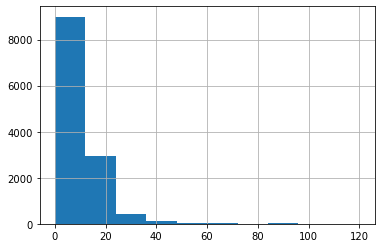

In [28]:
speeds_merged['diff'].hist(range=[0,120])

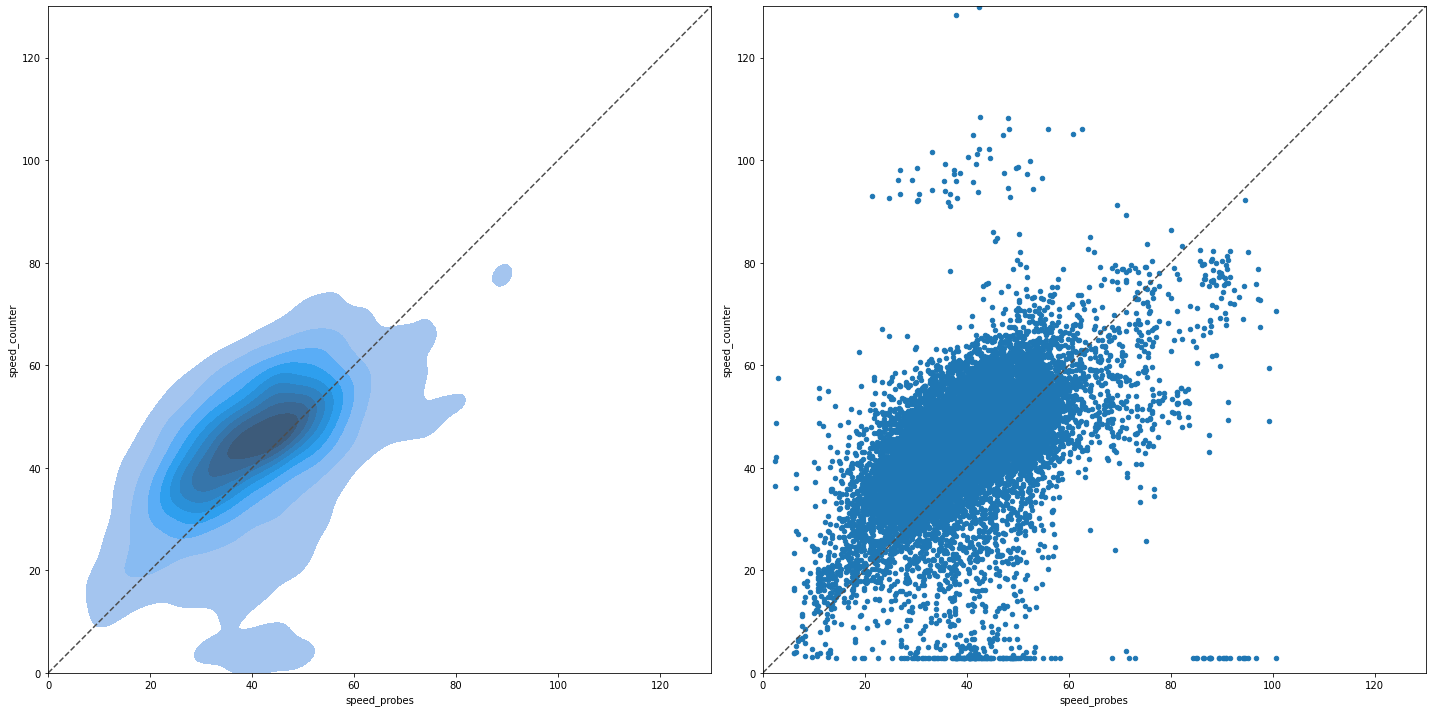

In [29]:
plot_scatters(speeds_merged)

<AxesSubplot:>

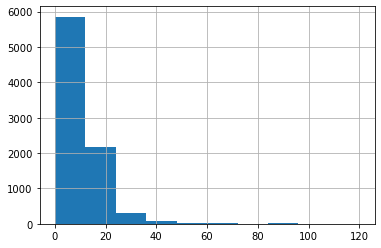

In [30]:
speeds_merged_day = speeds_merged[(speeds_merged['h'] > 6) & (speeds_merged['h'] < 23)]
speeds_merged_day['diff'].hist(range=[0,120])

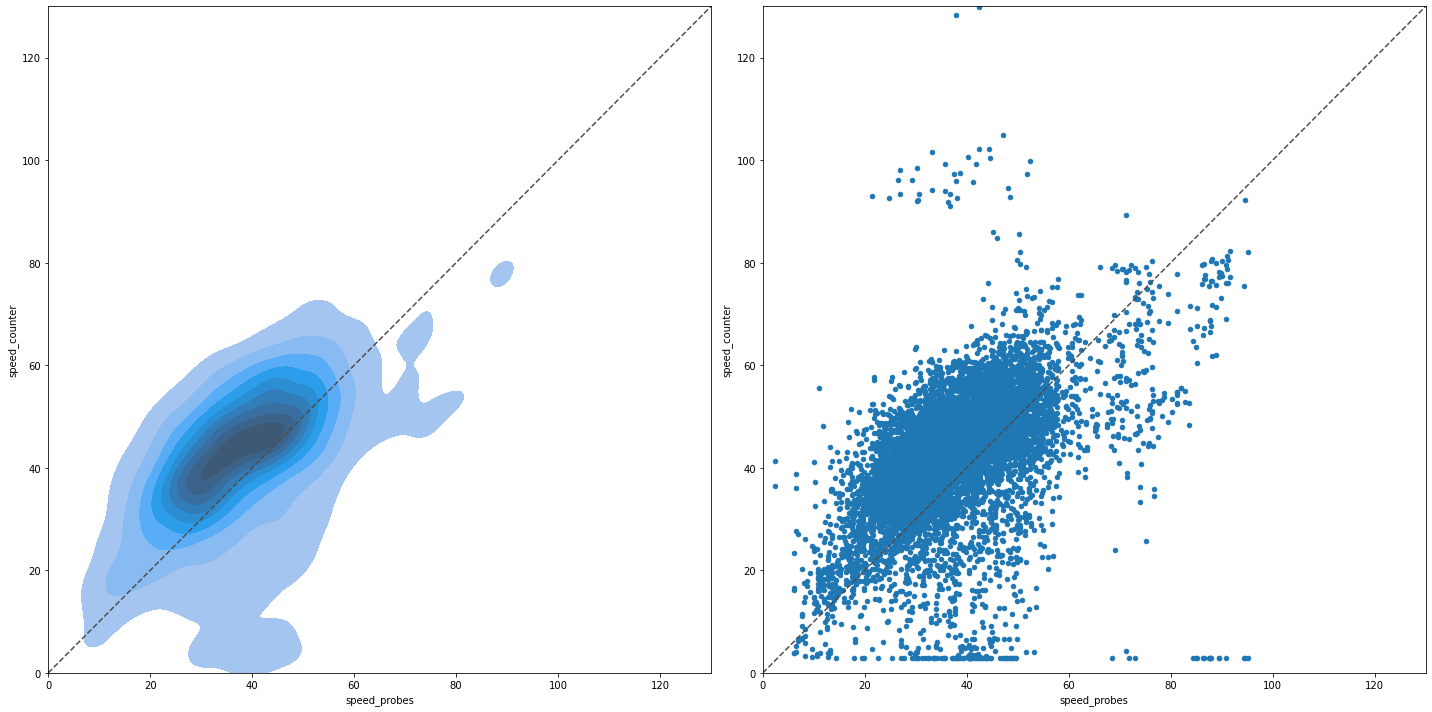

In [31]:
plot_scatters(speeds_merged_day)

In [32]:
speeds_merged[speeds_merged['diff'] > 50]

,id,tag,stunde,qualitaet,q_kfz_det_hr,v_kfz_det_hr,q_pkw_det_hr,v_pkw_det_hr,q_lkw_det_hr,v_lkw_det_hr,...,u,v,gkey,volume_class,volume_y,speed_probes,mean_speed_kph,std_speed_kph,free_flow_kph,diff
1,100101010000268,05.06.2019,0,1.0,88,3.0,88,3.0,0,-1.0,...,484310,27088394,-8786241051327056030,5.0,163.250000,90.274510,86.901664,12.106970,95.215686,87.274510
3,100101010000268,05.06.2019,1,1.0,35,3.0,35,3.0,0,-1.0,...,484310,27088394,-8786241051327056030,5.0,91.000000,91.539216,87.254902,13.405553,95.215686,88.539216
5,100101010000268,05.06.2019,2,1.0,22,3.0,22,3.0,0,-1.0,...,484310,27088394,-8786241051327056030,5.0,62.666667,90.810458,91.515152,9.404753,95.215686,87.810458
7,100101010000268,05.06.2019,3,1.0,17,3.0,17,3.0,0,-1.0,...,484310,27088394,-8786241051327056030,5.0,41.000000,94.147059,94.285146,4.401606,95.215686,91.147059
9,100101010000268,05.06.2019,4,1.0,52,3.0,52,3.0,0,-1.0,...,484310,27088394,-8786241051327056030,5.0,119.250000,100.686275,95.632947,19.957391,95.215686,97.686275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8166,100101010063421,05.06.2019,3,1.0,183,93.8,32,104.5,151,91.4,...,26703742,26982574,-6406341672349086153,5.0,37.250000,42.294118,40.566993,8.048892,50.588235,51.505882
8167,100101010063421,05.06.2019,4,1.0,143,108.4,62,130.4,81,91.5,...,26703742,26982574,-6406341672349086153,5.0,43.250000,42.598039,41.164216,6.377782,50.588235,65.801961
10427,100101010079181,05.06.2019,0,1.0,20,3.0,20,3.0,0,-1.0,...,344287213,29884236,-6882695422081375899,5.0,146.500000,53.137255,52.058824,3.973028,52.941176,50.137255
10439,100101010079181,05.06.2019,4,1.0,9,3.0,9,3.0,0,-1.0,...,344287213,29884236,-6882695422081375899,5.0,34.333333,56.470588,55.152194,4.489819,52.941176,53.470588


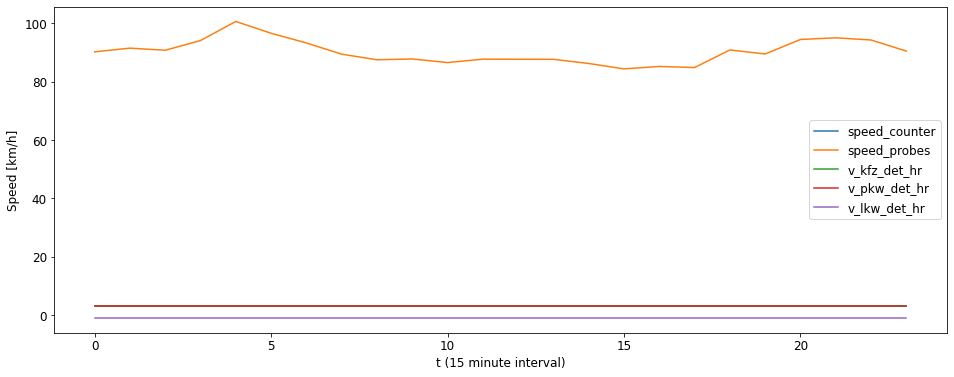

In [33]:
plot_speed_dayline(speeds_merged, 100101010000268, x_field="h")

In [35]:
plot_counter(counters_assigned_df, edges_df, 100101010000268)

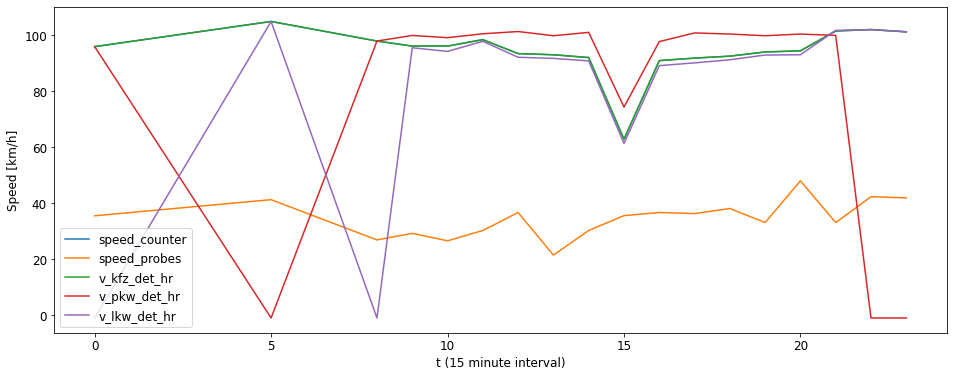

In [36]:
plot_speed_dayline(speeds_merged, 100101010033513, x_field="h")

In [37]:
plot_counter(counters_assigned_df, edges_df, 100101010033513)

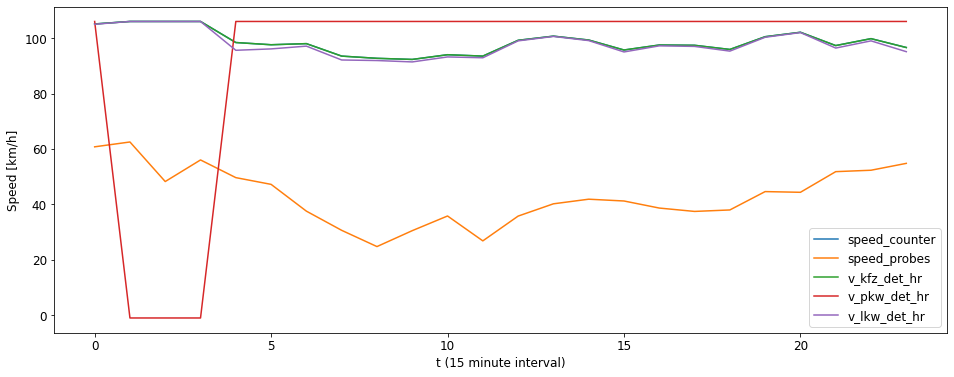

In [38]:
plot_speed_dayline(speeds_merged, 100101010039371, x_field="h")

In [39]:
plot_counter(counters_assigned_df, edges_df, 100101010039371)

Area (x in (0, 120), y in (0, 120) contains 12591 / 12596 readings (99.96%)
Readings are on 538 / 538 locations


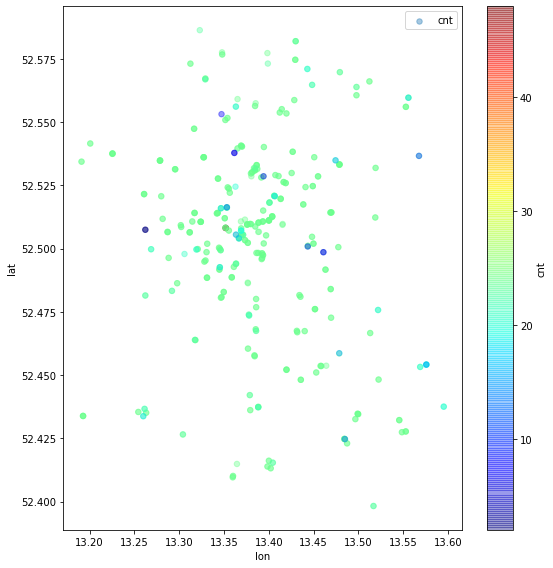

In [40]:
_ = inspect_diff_area(speeds_merged, 0, 120, 0, 120)

Area (x in (0, 120), y in (0, 120) contains 12591 / 12596 readings (99.96%)
Readings are on 538 / 538 locations


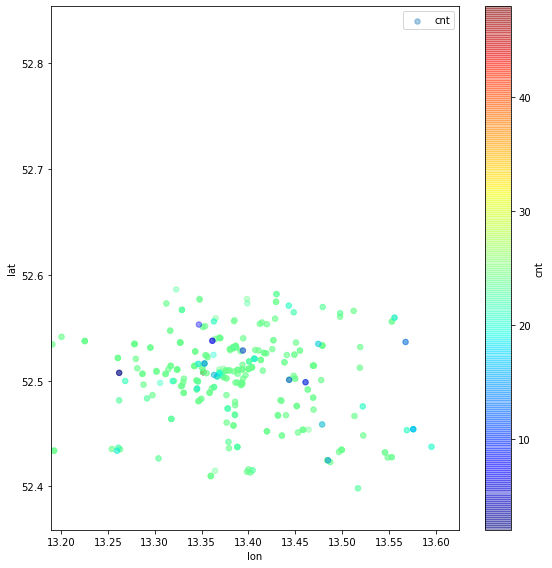

In [41]:
_ = inspect_diff_area(speeds_merged, 0, 120, 0, 120, bbox_city='berlin')

Area (x in (20, 120), y in (0, 5) contains 160 / 12601 readings (1.27%)
Readings are on 19 / 537 locations


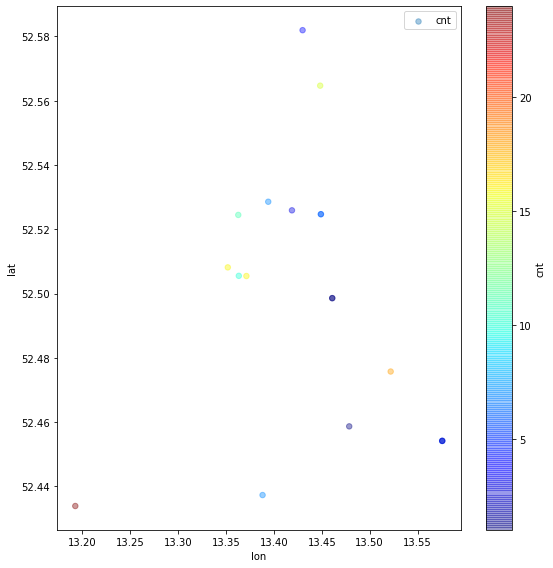

,id,lat,lon,cnt
0,100101010000268,52.433868,13.192578,24
1,100101010021183,52.475723,13.521929,18
2,100101010023409,52.505443,13.371263,16
4,100101010024015,52.508134,13.351842,16
5,100101010027247,52.564688,13.448316,15
14,100101010063421,52.524456,13.362778,11
3,100101010023712,52.505503,13.363336,10
6,100101010027550,52.524680,13.449052,8
8,100101010030681,52.528565,13.394072,7
10,100101010033412,52.454123,13.575724,7


In [34]:
inspect_diff_area(speeds_merged, 20, 120, 0, 5)

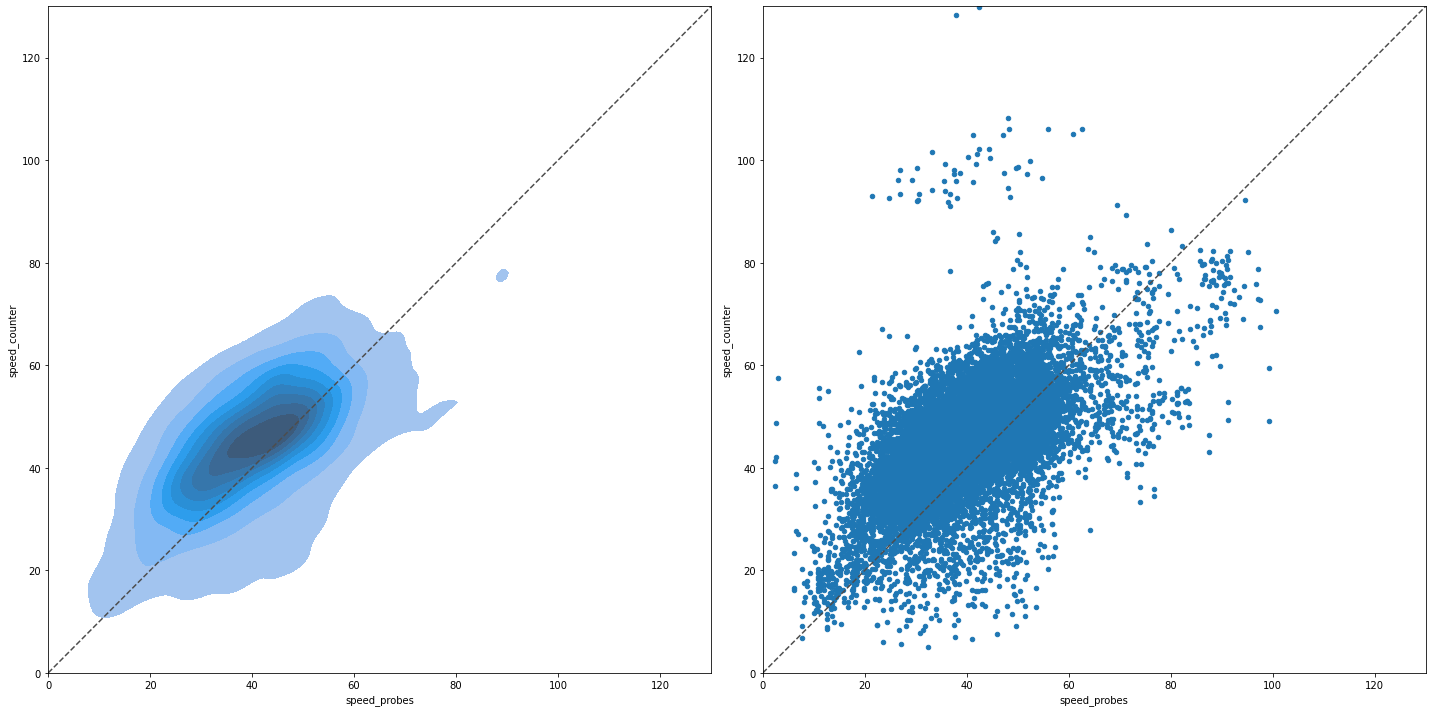

In [46]:
speeds_merged_filtered = speeds_merged[~speeds_merged['id'].isin(
    [100101010000268, 100101010021183, 100101010023409, 100101010023712, 100101010024015, 100101010027247, 100101010027550, 100101010027651, 100101010030681, 100101010033311, 100101010033412, 100101010033614, 100101010040886, 100101010054731, 100101010063421, 100101010068269, 100101010068370, 100101010079181, 100101010082215]
)]

plot_scatters(speeds_merged_filtered)

In [44]:
speeds_merged.to_parquet(COUNTER_PATH / 'berlin' / 'speeds_merged_berlin.parquet', compression="snappy")

In [48]:
speeds_merged_filtered.to_parquet(
    COUNTER_PATH / 'berlin' / 'speeds_merged_clean_berlin.parquet', compression="snappy")

In [37]:
speeds_merged_filtered[['id', 'u', 'v', 'gkey']]

,id,u,v,gkey
0,100101010000167,484310,27088394,-7876585987730032488
2,100101010000167,484310,27088394,-7876585987730032488
4,100101010000167,484310,27088394,-7876585987730032488
6,100101010000167,484310,27088394,-7876585987730032488
8,100101010000167,484310,27088394,-7876585987730032488
...,...,...,...,...
12765,100101010099995,26736159,26708460,6296702170848070074
12766,100101010099894,26736159,26708460,6296702170848070074
12767,100101010099995,26736159,26708460,6296702170848070074
12768,100101010099894,26736159,26708460,6296702170848070074


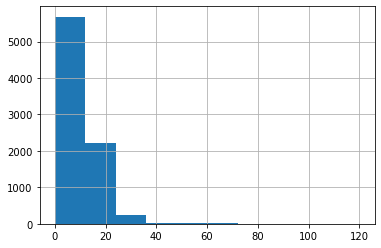

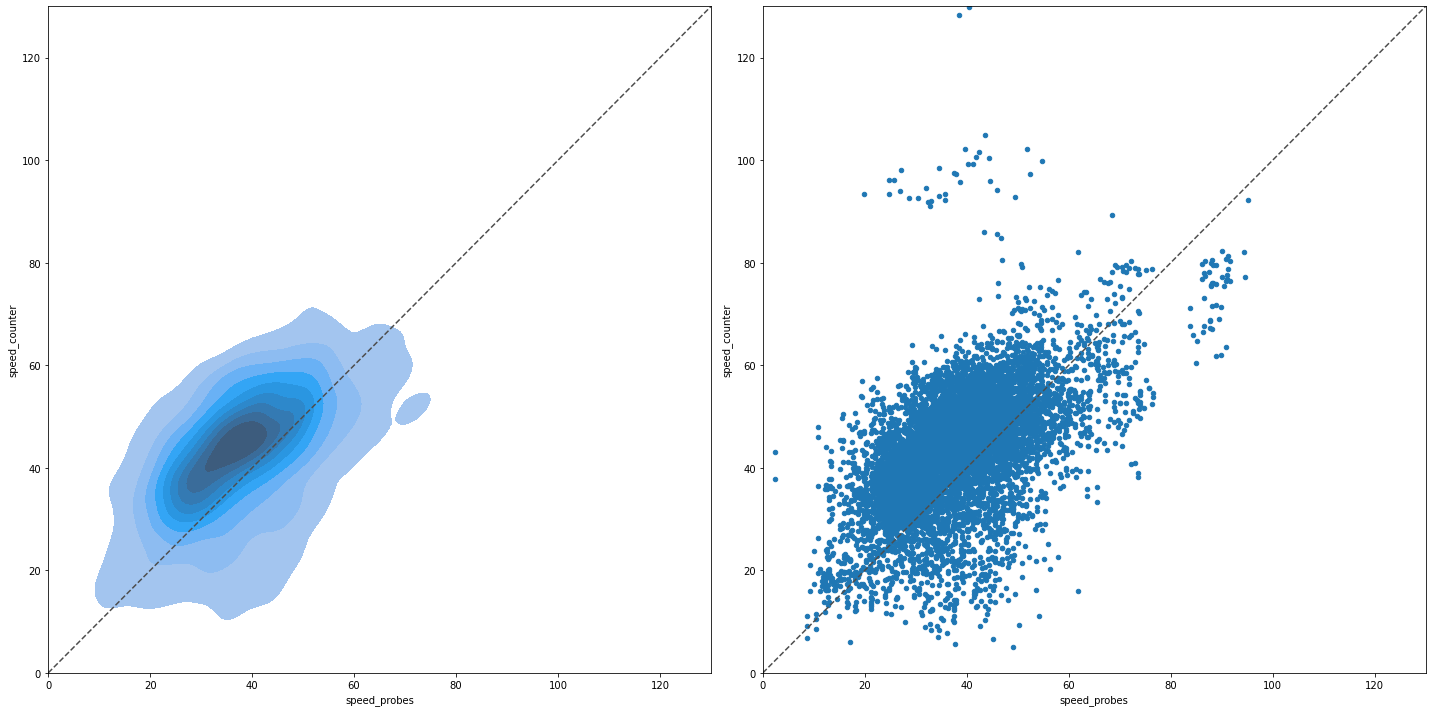

In [38]:
speeds_merged_filtered_day = speeds_merged_filtered[
    (speeds_merged_filtered['h'] > 6) & (speeds_merged_filtered['h'] < 23)]
speeds_merged_filtered_day['diff'].hist(range=[0,120])
plot_scatters(speeds_merged_filtered_day)

Area (x in (0, 70), y in (80, 120) contains 38 / 8193 readings (0.46%)
Readings are on 7 / 518 locations


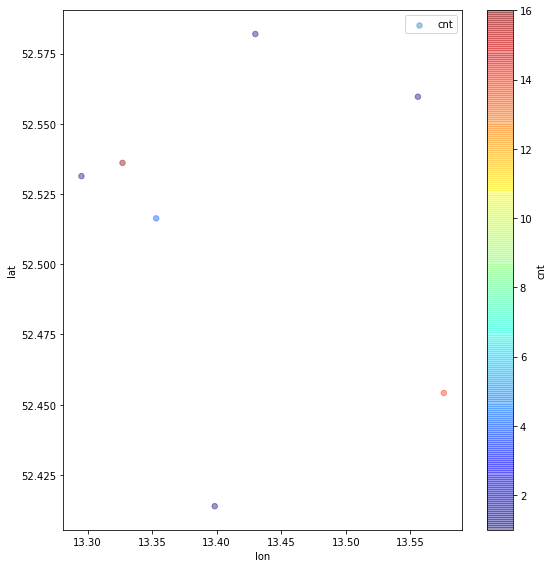

,id,lat,lon,cnt
3,100101010039371,52.536073,13.327092,16
2,100101010033513,52.454167,13.575866,14
1,100101010024924,52.516329,13.353151,4
0,100101010018456,52.413875,13.398483,1
4,100101010040179,52.559622,13.555812,1
5,100101010040785,52.581949,13.429938,1
6,100101010043415,52.531366,13.295307,1


In [39]:
day_top_left = inspect_diff_area(speeds_merged_filtered_day, 0, 70, 80, 120)
day_top_left.head(10)

In [40]:
plot_counter(counters_assigned_df, edges_df, 100101010039371)
# next to the wholesale market?

Area (x in (30, 70), y in (0, 15) contains 51 / 8193 readings (0.62%)
Readings are on 27 / 518 locations


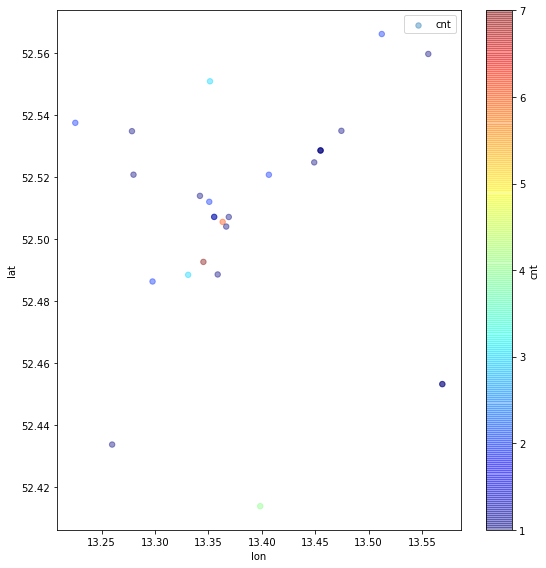

,id,lat,lon,cnt
22,100101010061300,52.492614,13.345310,7
11,100101010023813,52.505503,13.363336,6
7,100101010018456,52.413875,13.398483,4
17,100101010041900,52.488440,13.331041,3
1,100101010008453,52.550813,13.351478,3
26,100101010081912,52.520696,13.406579,2
4,100101010016537,52.537432,13.225404,2
6,100101010017446,52.486298,13.297705,2
20,100101010055741,52.566055,13.512272,2
19,100101010053721,52.507114,13.355402,2


In [41]:
day_bottom_left = inspect_diff_area(speeds_merged_filtered_day, 30, 70, 0, 15)
day_bottom_left.head(10)

In [42]:
plot_counter(counters_assigned_df, edges_df, 100101010061300)
# next to the wholesale market?

Now on the day it looks already quite good.

Let's do some stats: how many diffs are +-10%

8193
2518
3712
4777
5697


<ipython-input-43-bb01c48fcd2b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_speeds_merged['pdiff'] = good_speeds_merged['diff'] / good_speeds_merged['free_flow_kph'] * 100


<AxesSubplot:>

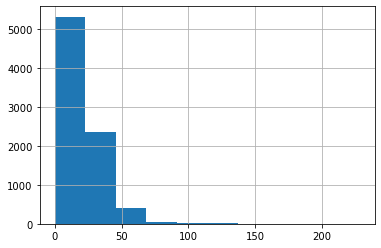

In [43]:
good_speeds_merged = speeds_merged_filtered_day
# good_speeds_merged = speeds_merged_filtered_day[speeds_merged_filtered_day['id'].isin(good_ids)]
print(len(good_speeds_merged))
good_speeds_merged['pdiff'] = good_speeds_merged['diff'] / good_speeds_merged['free_flow_kph'] * 100
print(len(good_speeds_merged[good_speeds_merged['pdiff'] < 10]))
print(len(good_speeds_merged[good_speeds_merged['pdiff'] < 15]))
print(len(good_speeds_merged[good_speeds_merged['pdiff'] < 20]))
print(len(good_speeds_merged[good_speeds_merged['pdiff'] < 25]))
good_speeds_merged['pdiff'].hist()

In [44]:
# Try with speedlimit filter

In [45]:
edges_speed_limit = edges_df[['u', 'v', 'gkey', 'speed_kph']]
edges_speed_limit = edges_speed_limit.rename(columns={'speed_kph': 'speed_limit_kph'})
edges_speed_limit

,u,v,gkey,speed_limit_kph
0,172539,28255136,-3585495382407956155,50.0
1,172539,34694336,-6639681062207553747,50.0
2,172539,3977742457,5756284037972293635,50.0
3,172545,271370539,-2971994374488948741,50.0
4,172545,28345518,-8139084951326199178,50.0
...,...,...,...,...
10744,10073921810,664001597,-2616679833711988027,50.0
10745,10079302052,26982853,-6048705386941545762,50.0
10746,10125556312,47966062,533161109483607484,70.0
10747,10125556312,29859411,4901854902975883717,70.0


In [46]:
speeds_merged_speed_limit = speeds_merged.merge(edges_speed_limit, on=['u', 'v', 'gkey'])
print(len(speeds_merged_speed_limit))
speeds_merged_speed_limit = speeds_merged_speed_limit[
    speeds_merged_speed_limit['speed_counter'] < (speeds_merged_speed_limit['speed_limit_kph'] * 1.2)]
speeds_merged_speed_limit

12601


,id,tag,stunde,qualitaet,q_kfz_det_hr,v_kfz_det_hr,q_pkw_det_hr,v_pkw_det_hr,q_lkw_det_hr,v_lkw_det_hr,...,volume,way,u,v,gkey,volume_class,speed_probes,free_flow_kph,diff,speed_limit_kph
0,100101010000167,05.06.2019,0,1.0,259,74.3,223,74.9,36,71.0,...,259,"[81629728, 150912137]",484310,27088394,-7876585987730032488,5.0,91.539216,96.313725,17.239216,80.0
1,100101010000268,05.06.2019,0,1.0,88,3.0,88,3.0,0,-1.0,...,88,"[81629728, 150912137]",484310,27088394,-7876585987730032488,5.0,91.539216,96.313725,88.539216,80.0
2,100101010000167,05.06.2019,1,1.0,125,72.2,96,76.3,29,58.7,...,125,"[81629728, 150912137]",484310,27088394,-7876585987730032488,5.0,90.810458,96.313725,18.610458,80.0
3,100101010000268,05.06.2019,1,1.0,35,3.0,35,3.0,0,-1.0,...,35,"[81629728, 150912137]",484310,27088394,-7876585987730032488,5.0,90.810458,96.313725,87.810458,80.0
4,100101010000167,05.06.2019,2,1.0,108,67.8,63,76.7,45,55.4,...,108,"[81629728, 150912137]",484310,27088394,-7876585987730032488,5.0,94.147059,96.313725,26.347059,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12551,100101010099692,05.06.2019,23,1.0,50,31.1,47,31.1,3,31.0,...,50,"[724621035, 1100784997, 327805902]",26736196,26736127,-3323162428936997225,5.0,34.823529,38.588235,3.723529,30.0
12573,100101010099894,05.06.2019,10,1.0,442,33.3,418,33.8,24,26.0,...,442,"[1100784996, 1056616525, 327805903]",26736159,26708460,6296702170848070074,5.0,24.607843,40.000000,8.692157,30.0
12574,100101010099995,05.06.2019,10,1.0,622,34.7,578,34.9,44,32.6,...,622,"[1100784996, 1056616525, 327805903]",26736159,26708460,6296702170848070074,5.0,24.607843,40.000000,10.092157,30.0
12586,100101010099995,05.06.2019,16,1.0,593,35.9,575,36.3,18,23.7,...,593,"[1100784996, 1056616525, 327805903]",26736159,26708460,6296702170848070074,5.0,20.058824,40.000000,15.841176,30.0


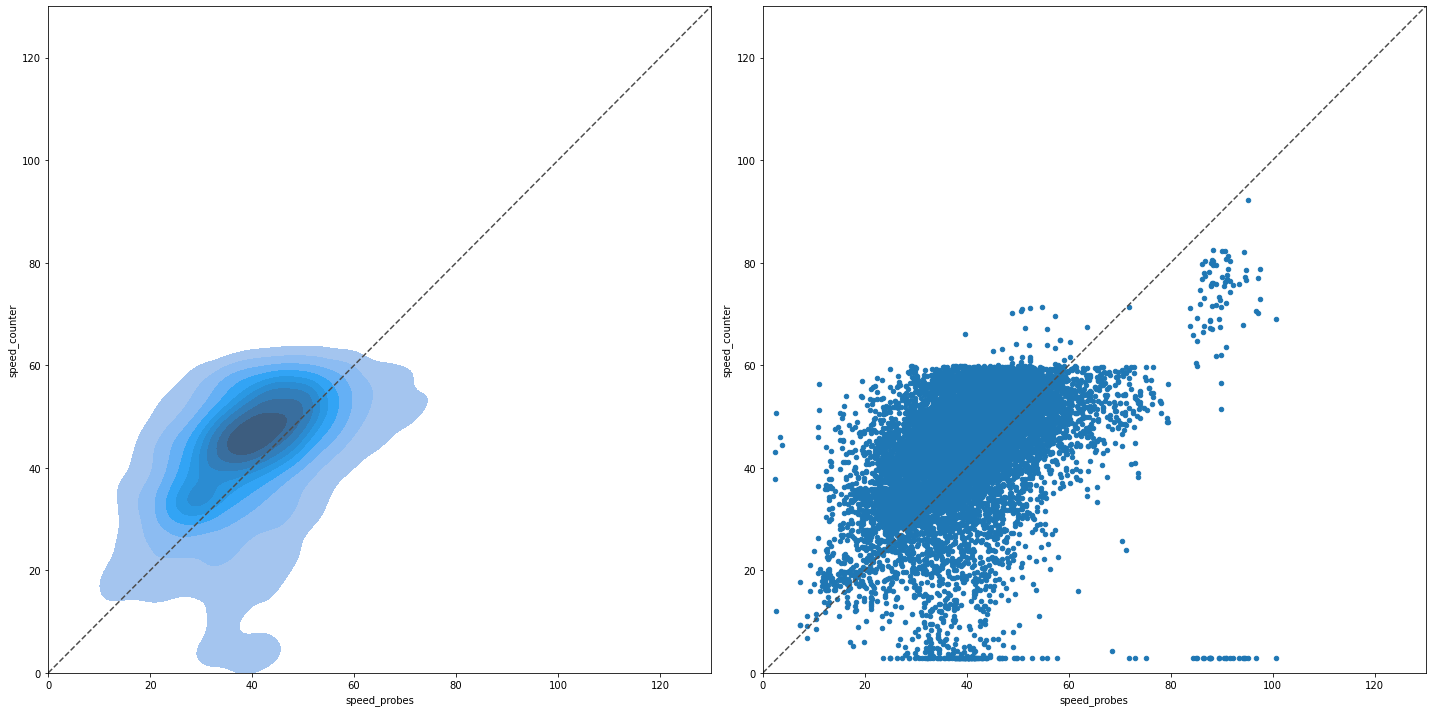

In [47]:
plot_scatters(speeds_merged_speed_limit)

In [48]:
len(speeds_merged_speed_limit['id'].unique())

523

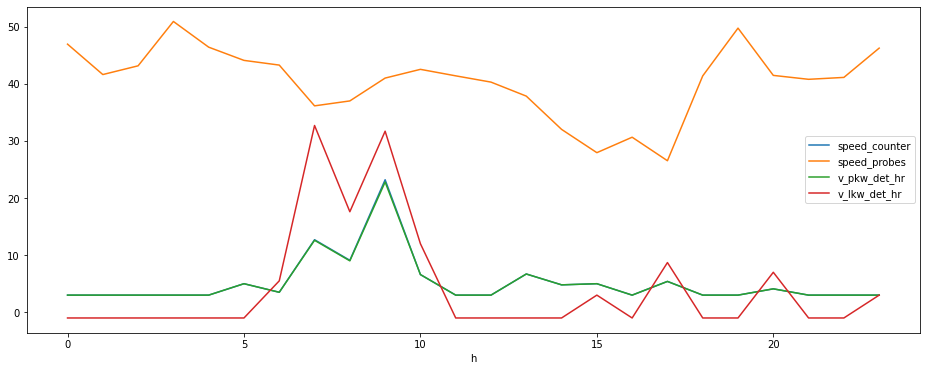

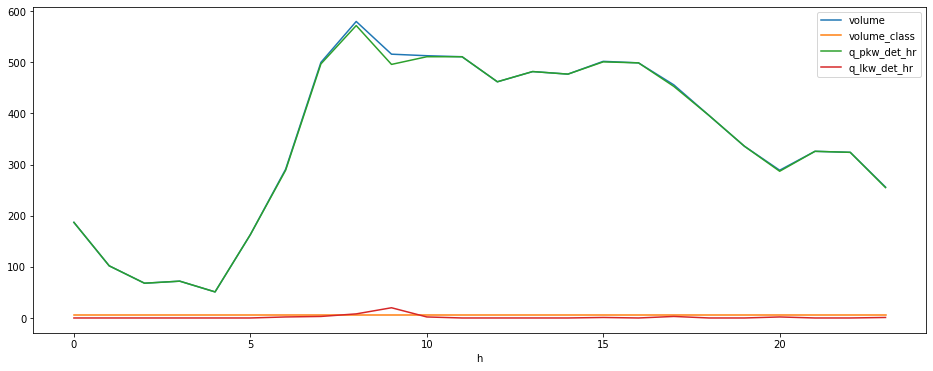

In [49]:
def plot_counter_daylines(id):
    speeds_merged[speeds_merged['id'] == id].plot(
        x="h", y=["speed_counter", "speed_probes", "v_pkw_det_hr", "v_lkw_det_hr",], figsize=(16,6))
    speeds_merged[speeds_merged['id'] == id].plot(
        x="h", y=["volume", "volume_class", "q_pkw_det_hr", "q_lkw_det_hr"], figsize=(16,6))

plot_counter_daylines(100101010024015)

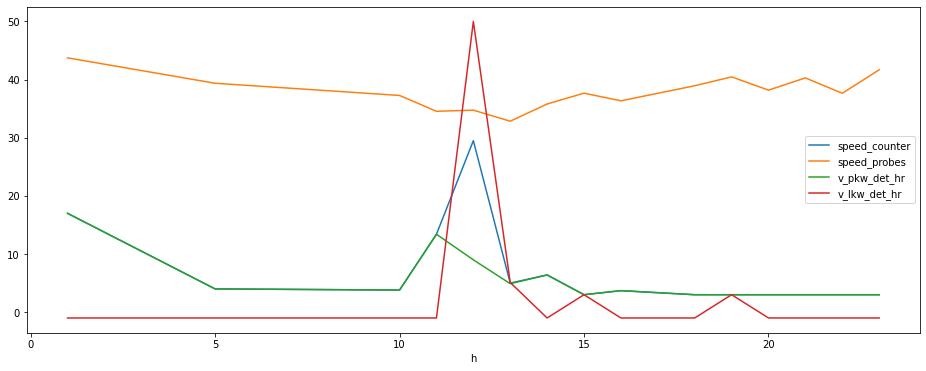

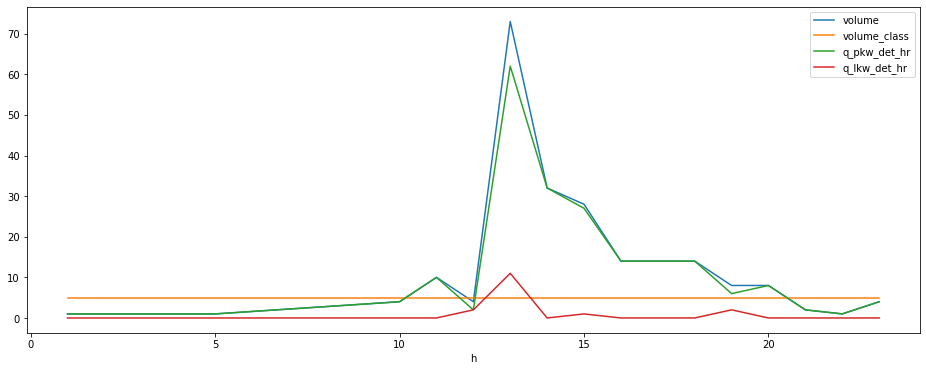

In [50]:
plot_counter_daylines(100101010023712)

In [55]:
hwt_ids = [
    100101010000167, 100101010000369, 100101010000470, # Spanische Allebrücke
    100101010004312, 100101010004413, 100101010004514, # Prenzlauer Promenade
    100101010040785, 100101010040987]  # Pasewalker Strasse

plot_counter(counters_assigned_df, edges_df, hwt_ids[0])

In [56]:
plot_counter(counters_assigned_df, edges_df, hwt_ids[1])

In [57]:
plot_counter(counters_assigned_df, edges_df, hwt_ids[2])

In [58]:
plot_counter(counters_assigned_df, edges_df, hwt_ids[3])

In [59]:
plot_counter(counters_assigned_df, edges_df, hwt_ids[4])

In [60]:
plot_counter(counters_assigned_df, edges_df, hwt_ids[5])

In [61]:
plot_counter(counters_assigned_df, edges_df, hwt_ids[6])

In [62]:
plot_counter(counters_assigned_df, edges_df, hwt_ids[7])

In [73]:
edges_df[(edges_df['speed_kph'] > 80)]['highway'].unique()

array(['motorway', 'secondary', 'trunk', 'motorway_link', 'primary',
       "['primary', 'trunk']", 'tertiary',
       "['primary_link', 'motorway_link']", "['secondary', 'tertiary']",
       "['motorway', 'motorway_link']"], dtype=object)

In [77]:
e2 = pd.read_parquet('/Users/neun/data/t4c/data_pipeline/release20220930/2021/road_graph/berlin/road_graph_edges.parquet')
e2

,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry
0,172539,28255136,"[622326987, 673699601, 147432151, 147432152, 1...",50.0,50,tertiary,False,2,nan,1295.524,b'\x01\x02\x00\x00\x00?\x00\x00\x00\x94\x84D\x...
1,172539,34694336,5117633,50.0,50,secondary,False,2,nan,687.484,b'\x01\x02\x00\x00\x00\x16\x00\x00\x00\x94\x84...
2,172539,3977742457,"[31740296, 33231778]",50.0,50,secondary,False,2,nan,391.153,b'\x01\x02\x00\x00\x00\x0c\x00\x00\x00\x94\x84...
3,172545,271370539,24973218,50.0,50,tertiary,False,nan,nan,17.179,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\x94=\xf...
4,172545,28345518,4546470,50.0,50,tertiary,False,2,nan,430.443,b'\x01\x02\x00\x00\x00\x10\x00\x00\x00\x94=\xf...
...,...,...,...,...,...,...,...,...,...,...,...
10773,9980209443,213215575,"[387211428, 30885574, 256007113, 256007114, 42...",50.0,50,secondary,True,"['4', '2']",nan,514.342,"b""\x01\x02\x00\x00\x00\x15\x00\x00\x00\xa6X\x7..."
10774,9982763016,427681012,"[1089784289, 1089784296, 1089784297, 108978429...",50.0,50,tertiary,False,"['2', '3']",yes,1214.302,b'\x01\x02\x00\x00\x004\x00\x00\x00(|[U\x9b\x0...
10775,9982763016,55198679,"[891226625, 147557793, 1077057091, 1090755253,...",50.0,50,tertiary,False,2,nan,849.074,b'\x01\x02\x00\x00\x00%\x00\x00\x00(|[U\x9b\x0...
10776,9982763016,12614668,"[1093545315, 28818693, 1089792553, 27959249, 7...",50.0,50,tertiary,False,"['2', '3']",nan,404.194,b'\x01\x02\x00\x00\x00\x19\x00\x00\x00(|[U\x9b...


In [79]:
e2[(e2['speed_kph'] > 80)]['highway'].unique()

array(['motorway', 'secondary', 'trunk', 'motorway_link', 'primary',
       'tertiary', "['primary_link', 'motorway_link']",
       "['motorway_link', 'motorway']"], dtype=object)